# 7.5.1 Generative Adversarial Networks (GAN)

## Explanation of Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are a class of machine learning frameworks designed for unsupervised learning tasks. Introduced by Ian Goodfellow and colleagues in 2014, GANs consist of two neural networks: a generator and a discriminator. These two networks are trained simultaneously through adversarial processes:

- **Generator**: The generator creates synthetic data samples from random noise. Its goal is to generate data that is indistinguishable from real data.
- **Discriminator**: The discriminator evaluates the authenticity of the data samples. It attempts to distinguish between real data (from the training dataset) and fake data (produced by the generator).

The generator and discriminator engage in a minimax game where the generator tries to fool the discriminator, and the discriminator tries to accurately classify the real and fake data. Through this process, both networks improve their performance until the generator produces highly realistic data samples.


## Applications and Benefits of GANs

GANs have a wide range of applications and benefits, including but not limited to:

- **Image Generation**: GANs can generate realistic images from noise, which is useful in art, design, and creating synthetic datasets for training other models.
- **Data Augmentation**: GANs can create additional training data, helping improve the performance of machine learning models, especially when limited data is available.
- **Super-Resolution**: GANs can enhance the resolution of images, making them clearer and more detailed.
- **Image-to-Image Translation**: GANs can translate images from one domain to another, such as converting sketches to photographs or daytime scenes to nighttime scenes.
- **Text-to-Image Synthesis**: GANs can generate images based on textual descriptions, enabling applications in content creation and visualization.
- **Anomaly Detection**: GANs can help detect anomalies by learning the distribution of normal data and identifying outliers.

The benefits of GANs include their ability to generate high-quality synthetic data, their flexibility in various domains, and their contribution to advancing machine learning research and applications.


___
___
### **Readings:**
- [GAN — What is Generative Adversarial Networks GAN?](https://jonathan-hui.medium.com/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09)
- [Generative Adversarial Networks(GANs): End-to-End Introduction](https://www.analyticsvidhya.com/blog/2021/10/an-end-to-end-introduction-to-generative-adversarial-networksgans/)
- [Generative Adversarial Networks: Build Your First Models](https://realpython.com/generative-adversarial-networks/)
- [Applications of Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/)
- [GAN — GAN Series](https://jonathan-hui.medium.com/gan-gan-series-2d279f906e7b)
- [Deep Convolutional Generative Adversarial Network - TensorFlow](https://www.tensorflow.org/tutorials/generative/dcgan)
___
___

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load and preprocess the full MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [3]:
# Batch and shuffle the data
BUFFER_SIZE = 6000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(7*7*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

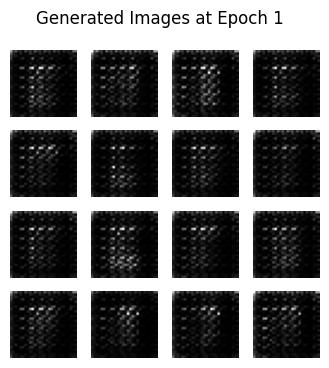

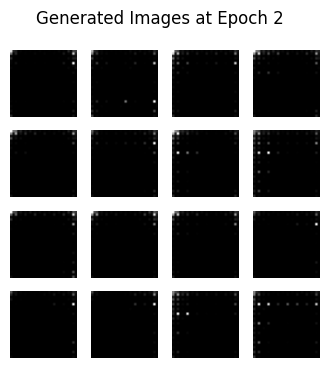

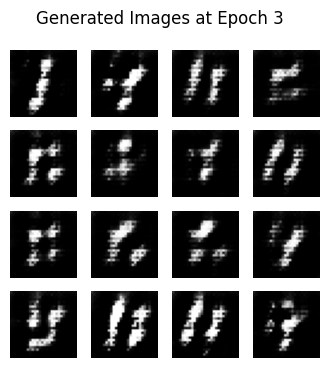

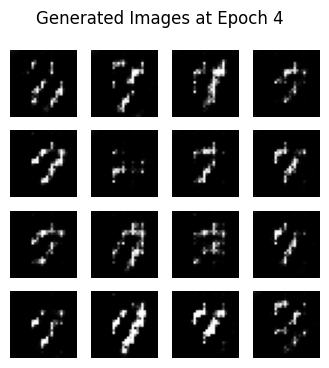

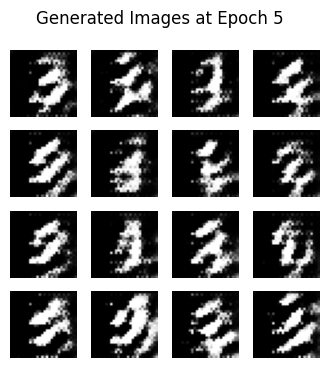

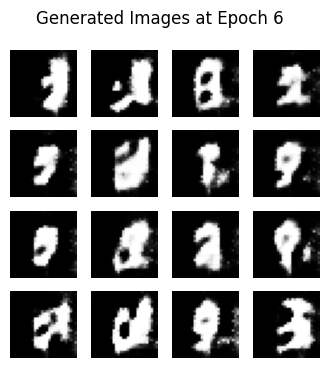

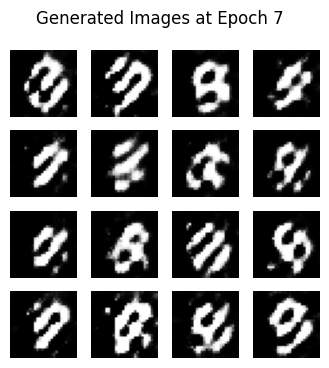

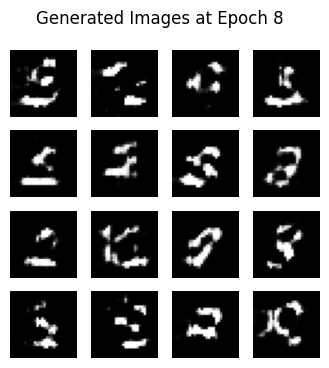

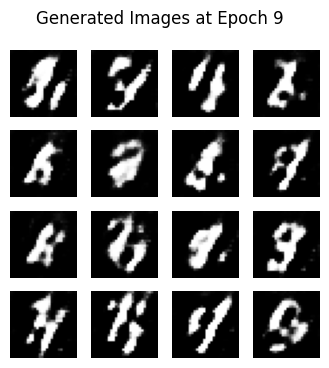

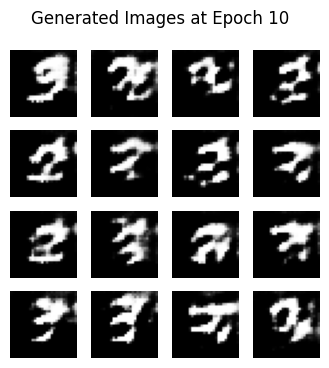

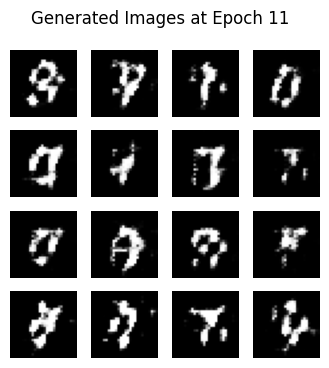

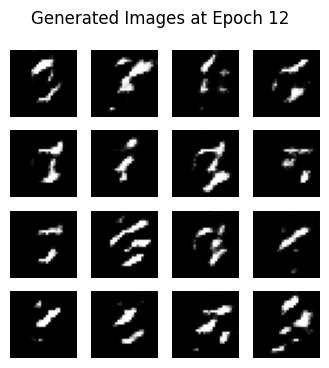

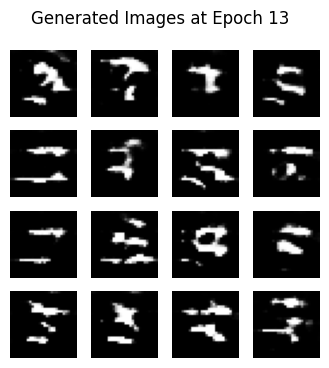

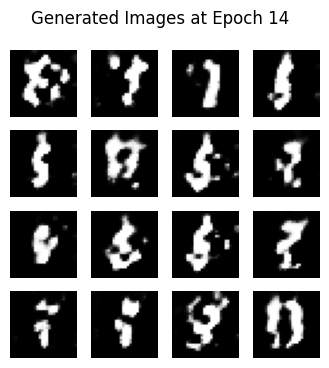

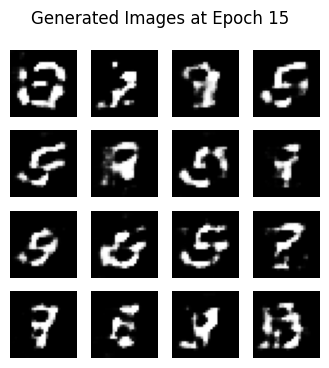

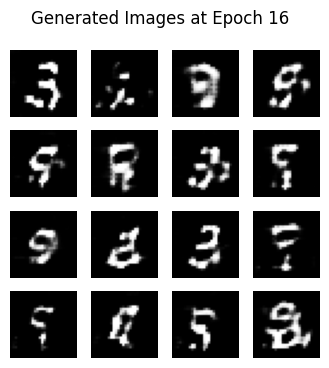

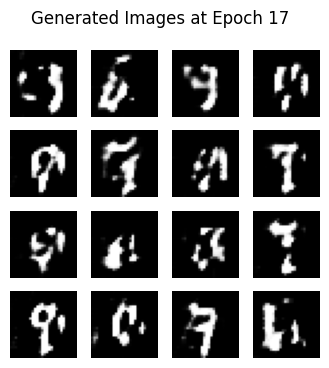

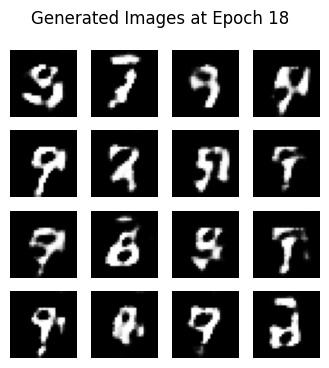

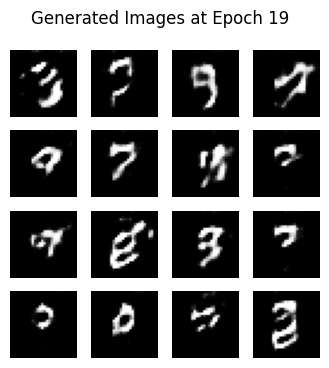

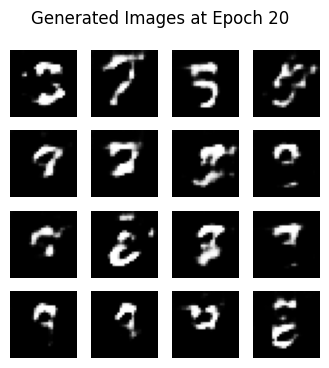

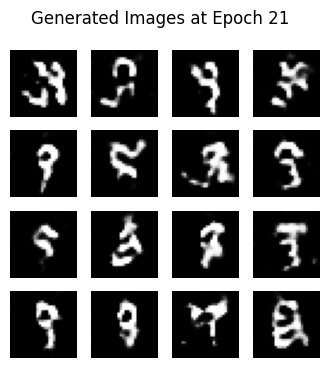

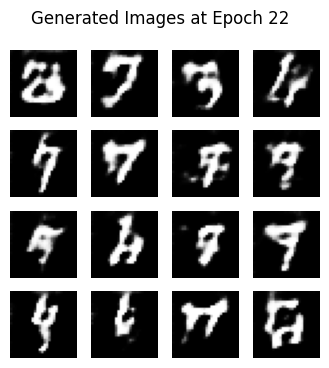

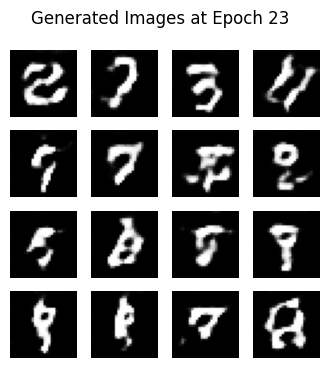

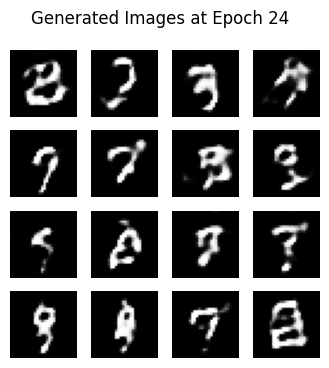

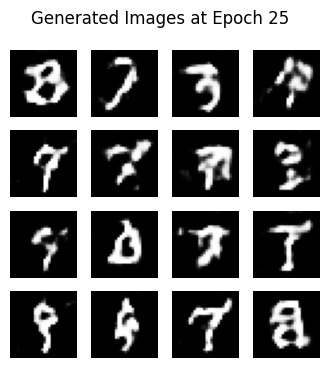

In [6]:
# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define loss functions
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for visualization
        generate_and_save_images(generator, epoch + 1, seed)

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    plt.suptitle(f'Generated Images at Epoch {epoch}')

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

# Set up parameters and seed
EPOCHS = 25  # Number of epochs for demonstration
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Train the model
train(train_dataset, EPOCHS)

## Conclusion

Generative Adversarial Networks (GANs) are a powerful and versatile tool in the field of machine learning. By leveraging the adversarial training process between the generator and discriminator, GANs can generate highly realistic synthetic data. This capability has numerous applications across various domains, including image generation, data augmentation, super-resolution, image-to-image translation, text-to-image synthesis, and anomaly detection. 

The example provided demonstrates the basic implementation of a GAN using the MNIST dataset. It showcases the core components and training process, highlighting how GANs can be used to create synthetic images. As GANs continue to evolve, they hold great potential for further advancements and applications in machine learning and artificial intelligence.
